In [ ]:
import matplotlib.pyplot as plt
import timeit 
import statistics 
from exact import exact
from sampling import sampling

### Exact Algorithm

In [93]:
# gather frequency of all items for each dataset
accidents_freq = exact(0, "./datasets/accidents.dat")
kosarak_freq = exact(0, "./datasets/kosarak.dat")
webdocs_freq = exact(0, "./datasets/webdocs.dat")

In [149]:
# method for plotting frequency distribution
def visualize(dataset: str, freq: list[tuple[int, float]], xsc="linear", ysc="linear"):
    # keys:values = frequency threshold:|F(D,thres)|/|I|
    dist = {}
    for i in range(len(freq)):
        dist[freq[i][1]] = (i + 1) / len(freq)

    # plot frequency distribution
    plt.scatter(dist.keys(), dist.values(), marker=".")
    plt.title(dataset)
    plt.xlabel("threshold")
    plt.xscale(xsc)
    plt.yscale(ysc)
    plt.ylabel("|F(D,threshold)| / |I|")

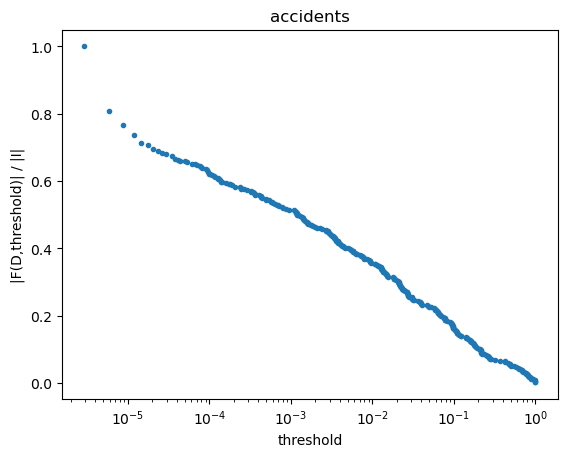

In [154]:
visualize("accidents", accidents_freq, xsc="log")

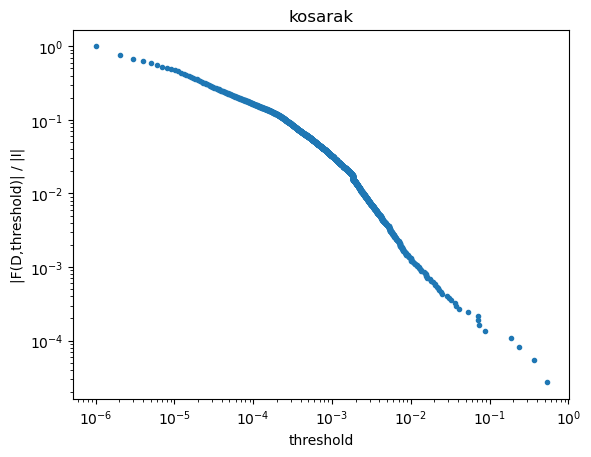

In [151]:
visualize("kosarak", kosarak_freq, xsc="log", ysc="log")

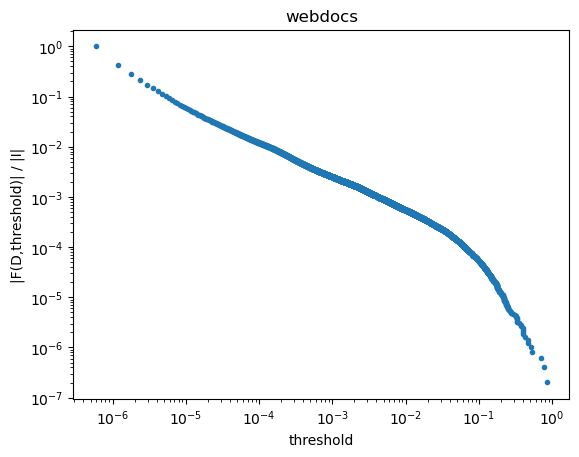

In [152]:
visualize("webdocs", webdocs_freq, ysc="log", xsc="log")

For each plot, we can clearly see that the percentage of items included in the output set decreases as threshold increases. For the 'accidents' dataset, the trend appears linear with a logarithmic x axis, meaning that the percentage is proportional to -log(threshold). 

The datasets 'kosarak' and 'webdocs' follow a different trend. They both appear fairly linear on log axes, with a sudden tilt downwards partway through. The shape of these curves indicates that the percentage is proportional to 1/(thres^c) with c a constant, and the value of c shifts (increases) at some point as threshold increases. This happens earlier in 'kosarak' than in 'webdocs.' In other words, the percentage of items above a given frequency threshold begins decreasing faster earlier (for lower values of thres) in 'kosarak' than in 'webdocs.'

### Sampling-based Algorithm

Parameters: I am using the accidents dataset, with frequency threshold 0.1 and delta 0.1. The sample sizes I have selected are 5%, 15%, 50%, and 75% of the total dataset size.

In [ ]:
# method for gathering execution time excluding return of one run
def timer(func, *args, num=1):
    stmt = lambda: func(*args)
    return timeit.timeit(stmt, number=num)

In [ ]:
# set constant parameters
dataset = "./datasets/accidents.dat"
dsize = 3401830
delta = 0.1
thres = 0.1

# sampling-based algorithm results and timing
sizes = [int(dsize * x) for x in [0.05, 0.15, 0.5, 0.75]]
sresults = {} # sample size : [(runtime, output)]
for s in sizes:
    sresult = []
    for j in range(5):
        # individually gather time and output
        run = timer(sampling, s, dsize, delta, thres, dataset)
        out = sampling(s, dsize, delta, thres, dataset)
        sresult.append((run, out))
    sresults[s] = sresult

# exact algorithm timing and output
ethres_time = timer(exact, thres, dataset, num=5) # total time for 5 trials
ethres_out = exact(thres, dataset)

# calculate maxeps and recalculate exact frequent items
maxeps = max(sresults[int(0.05 * dsize)][i][1][0] for i in range(4))
emaxeps_out = exact(thres - maxeps, dataset)


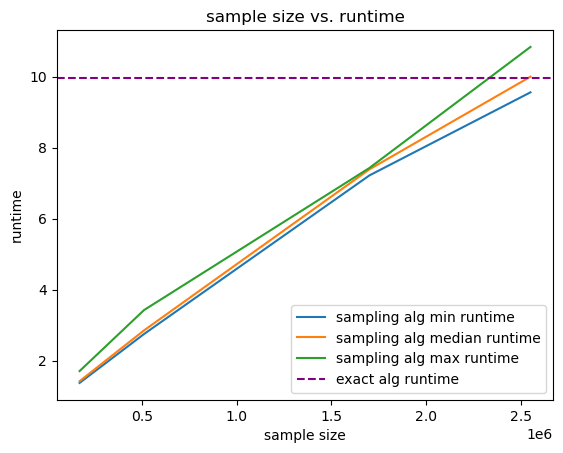

In [147]:
# plot runtime vs. sample size
plt.plot(sizes, [min(sresults[s][i][0] for i in range(5)) for s in sizes], label="sampling alg min runtime")
plt.plot(sizes, [statistics.median(sresults[s][i][0] for i in range(5)) for s in sizes], label="sampling alg median runtime")
plt.plot(sizes, [max(sresults[s][i][0] for i in range(5)) for s in sizes], label="sampling alg max runtime")
plt.axhline(y=ethres_time/5, linestyle="--", label="exact alg runtime", color="purple")

plt.title("sample size vs. runtime")
plt.xlabel("sample size")
plt.ylabel("runtime")
plt.legend()

This plot shows very clearly that runtime for the sampling algorithm scales linear with sample size. This relationship is in line with expectations, since an analysis of the code shows that time complexity for the sampling-based algorithm is (for the most part) a function of sample size. 

Meanwhile, the exact algorithm depends on the size of the entire dataset, and remains larger than the sampling algorithm runtime for all but the maximum. This intersection between sampling and exact runtimes at a sample size of around 2.5x10^6 transactions (~75% of the dataset) likely results from the time needed to generate the sample, and it can be expected that the sampling-based algorithm will take longer than the exact algorithm for any sample sizes past this point. 

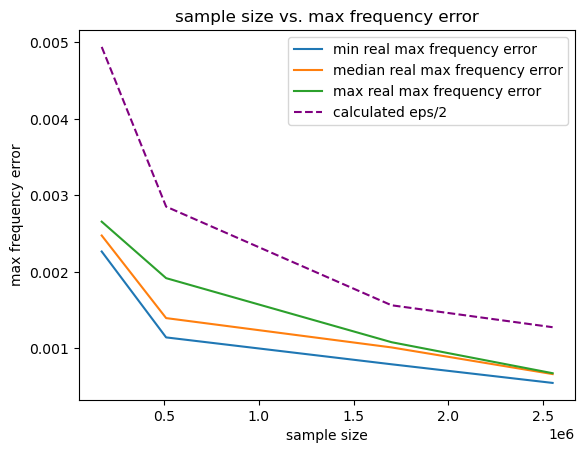

In [148]:
# find maximum frequency error for given trial
def maxdiff(sample, dataset):
    ds = dict(dataset)
    diff = 0
    for i in range(len(sample)):
        si, sf = sample[i]
        diff = max(diff, abs(sf - ds[si]))
    return diff

# real maximum frequency error and eps/2 vs. sample size
plt.plot(sizes, [min(maxdiff(sresults[s][i][1][1], emaxeps_out) for i in range(5)) for s in sizes], label="min real max frequency error")
plt.plot(sizes, [statistics.median(maxdiff(sresults[s][i][1][1], emaxeps_out) for i in range(5)) for s in sizes], label="median real max frequency error")
plt.plot(sizes, [max(maxdiff(sresults[s][i][1][1], emaxeps_out) for i in range(5)) for s in sizes], label="max real max frequency error")
plt.plot(sizes, [max(sresults[s][i][1][0]/2 for i in range(5)) for s in sizes], linestyle="--", color="purple", label="calculated eps/2")

plt.title("sample size vs. max frequency error")
plt.xlabel("sample size")
plt.ylabel("max frequency error")
plt.legend()

As can be expected, both the real and calculated maximum frequency error decrease as sample size increases. We can also see that the sampling-based algorithm works as an epsilon approximation for the exact frequencies, since the maximum values for frequency error remain below epsilon/2 for each point. It is cool to see how closely the shape of the real frequency error curves match that of epsilon/2 — I would be interested to learn more about how the equation for this bound is derived.